In [1]:
import numpy as np
import pandas as pd
import time
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
import os

%load_ext autoreload
%autoreload 2
# %matplotlib notebook
%matplotlib inline

In [2]:
# body_part = "head"
# file_names = ['./data/training_data/head_data_1.log',
#              './data/training_data/head_data_2.log',
#              './data/training_data/head_data_3.log',
#              './data/training_data/head_data_4.log',
#              './data/training_data/head_data_5.log',
#              './data/training_data/head_data_6.log']

body_part = "shoulder_right"
file_names = [
             './data/training_data/shoulder_right_data_6.log',
             './data/training_data/shoulder_right_data_7.log',
             './data/training_data/shoulder_right_data_8.log',
             './data/training_data/shoulder_right_data_9.log',
             './data/training_data/shoulder_right_data_14.log',
             './data/training_data/shoulder_right_data_15.log',
             './data/training_data/shoulder_right_data_16.log',
             './data/training_data/shoulder_right_data_17.log']

# body_part = "shoulder_left"
# file_names = ['./data/training_data/shoulder_left_data_1.log',
#               './data/training_data/shoulder_left_data_2.log',
#               './data/training_data/shoulder_left_data_3.log']

dataset = [pd.read_csv(f, delim_whitespace=True, header=0) for f in file_names]
# dataset = [data[(np.abs(stats.zscore(data[["mx0", "my0", "mz0"]])) < 2.75).all(axis=1)] for data in dataset]
# dataset = [data[(np.abs(stats.zscore(data[["mx1", "my1", "mz1"]])) < 2.75).all(axis=1)] for data in dataset]
# dataset = [data[(np.abs(stats.zscore(data[["mx2", "my2", "mz3"]])) < 2.75).all(axis=1)] for data in dataset]
# dataset = [data[(np.abs(stats.zscore(data[["mx3", "my3", "mz3.1"]])) < 2.75).all(axis=1)] for data in dataset]
dataset = [data[(np.abs(stats.zscore(data[["roll", "pitch", "yaw"]])) < 2.75).all(axis=1)] for data in dataset]
dataset_len = [len(data) for data in dataset]
dataset = pd.concat(dataset)

print('%d values'%(len(dataset)))

346086 values


In [3]:
dataset_len

[8241, 67523, 37184, 57790, 12928, 12195, 7290, 142935]

In [4]:
dataset = dataset.values[1:len(dataset)-1,0:]
# np.random.shuffle(dataset)

dataset = dataset[abs(dataset[:,12])!=0.0,:]
dataset = dataset[abs(dataset[:,13])!=0.0,:]
dataset = dataset[abs(dataset[:,14])!=0.0,:]
print('%d values after filtering outliers'%(len(dataset)))

euler_set = dataset[:, 12:15]
print('max euler ' + str(np.amax(euler_set)))
print('min euler ' + str(np.amin(euler_set)))
sensors_set = dataset[:, :12]

346084 values after filtering outliers
max euler 1.411555809406252
min euler -2.2710370734661414


In [5]:
from tools import *

In [6]:
# euler_set = torch.Tensor(euler_set).cuda()
# rot_set = compute_rotation_matrix_from_euler(euler_set)
# quad_set = compute_quaternions_from_rotation_matrices(rot_set)
# quad_set = quad_set.cpu().detach().numpy()

In [7]:
sin_cos_set = np.hstack([np.sin(euler_set), np.cos(euler_set)])

In [8]:
sensors_scaler = MinMaxScaler(feature_range=(-1., 1.))
sensors_set = sensors_scaler.fit_transform(sensors_set)

In [9]:
look_back = 10

data_in = []
data_out = []

start_idx = 0
for l in dataset_len:
    # Ignore the last batch
    for i in range(start_idx, start_idx+l-look_back*2):
        data_in.append(sensors_set[i:i+look_back])
        data_out.append(sin_cos_set[i+1:i+look_back+1])
    print(len(data_in))
    start_idx += l

8221
75724
112888
170658
183566
195741
203011
345926


In [10]:
data_split = 0.8
data_idx = np.arange(len(data_in))
np.random.shuffle(data_idx)
split_idx = int(len(data_in)*data_split)

train_in = np.array(data_in)[data_idx[:split_idx]]
train_out = np.array(data_out)[data_idx[:split_idx]]
test_in = np.array(data_in)[data_idx[split_idx:]]
test_out = np.array(data_out)[data_idx[split_idx:]]

In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [12]:
device = "cuda"
train_in = Variable(torch.Tensor(train_in)).to(device)
train_out = Variable(torch.Tensor(train_out)).to(device)
test_in = Variable(torch.Tensor(test_in)).to(device)
test_out = Variable(torch.Tensor(test_out)).to(device)

In [13]:
train_in.device

device(type='cuda', index=0)

## Train model

In [14]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.tanh = nn.Tanh()

    def forward(self, x):
        bs, sl, _ = x.size()
        
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        lstm_out = ula.contiguous().view(-1, self.hidden_size)
        
        out = self.fc(lstm_out)
        out = self.tanh(out)
        out = out.view(bs, sl, 6)
        
        return out

In [15]:
def mse_seq(x, y):
    return torch.square(x - y).sum(-1).mean()

In [16]:
num_epochs = 500
learning_rate = 5e-4
batch_size = 500

input_size = train_in.size()[-1]
hidden_size = 100
num_layers = 2
num_classes = 6

model = LSTM(num_classes, input_size, hidden_size, num_layers)
model.to(device)

criterion = mse_seq # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

x = train_in
y = train_out
x_val = test_in
y_val = test_out

iteration = 500
patience = 500

cur_patience = 0
best_mse = 999.
n_train_batches = x.shape[0] // batch_size
n_valid_batches = x_val.shape[0] // batch_size
rand_idx = np.arange(x.shape[0])

for epoch in range(iteration):

    training_loss = 0.
    valid_loss = 0.

    np.random.shuffle(rand_idx)
    rand_in_train = x[rand_idx]
    rand_out_train = y[rand_idx]
    
    # Training
    model.train()

    for i in range(n_train_batches - 1):
        idx = slice(i * batch_size, i * batch_size + batch_size)

        minibatch_x = rand_in_train[idx]
        minibatch_y = rand_out_train[idx]

        # feed_dict = {
        #     self.x: minibatch_x,
        #     self.y: minibatch_y,
        # }

        # _, loss = self.session.run([self.step_op, self.mse], feed_dict)

        inputs, labels = minibatch_x.to(device), minibatch_y.to(device)
        model.zero_grad()
        output = model(inputs)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        training_loss += loss.item() / n_train_batches

    # Validating
    model.eval()
    
    for i in range(n_valid_batches - 1):
        
        idx = slice(i * batch_size, i * batch_size + batch_size)

        minibatch_x = x_val[idx]
        minibatch_y = y_val[idx]
        
        inputs, labels = minibatch_x.to(device), minibatch_y.to(device)
        output = model(inputs)
        loss = criterion(output.squeeze(), labels.float()).item()
        
        # feed_dict = {
        #     self.x: minibatch_x,
        #     self.y: minibatch_y,
        # }

        # y_pred, loss = self.session.run([self.output, self.mse], feed_dict)

        valid_loss += loss / n_valid_batches

    if valid_loss < best_mse:
        best_mse = valid_loss
        # self.save_model(save_path)
        cur_patience = 0
    else:
        cur_patience += 1

    if epoch % 10 == 0:
        print("#%04d: Traing loss %.5f, Valid loss %.5f" % (epoch, training_loss, valid_loss))

    if cur_patience >= patience:
        print("Stop training after %04d iterations" % epoch)
        break

#0000: Traing loss 0.36678, Valid loss 0.07490
#0010: Traing loss 0.00491, Valid loss 0.00458
#0020: Traing loss 0.00255, Valid loss 0.00249
#0030: Traing loss 0.00189, Valid loss 0.00184
#0040: Traing loss 0.00163, Valid loss 0.00167
#0050: Traing loss 0.00139, Valid loss 0.00140
#0060: Traing loss 0.00130, Valid loss 0.00128
#0070: Traing loss 0.00120, Valid loss 0.00117
#0080: Traing loss 0.00111, Valid loss 0.00110
#0090: Traing loss 0.00106, Valid loss 0.00105
#0100: Traing loss 0.00104, Valid loss 0.00098
#0110: Traing loss 0.00094, Valid loss 0.00128
#0120: Traing loss 0.00091, Valid loss 0.00092
#0130: Traing loss 0.00085, Valid loss 0.00105
#0140: Traing loss 0.00082, Valid loss 0.00086
#0150: Traing loss 0.00080, Valid loss 0.00082
#0160: Traing loss 0.00080, Valid loss 0.00079
#0170: Traing loss 0.00076, Valid loss 0.00085
#0180: Traing loss 0.00074, Valid loss 0.00075
#0190: Traing loss 0.00073, Valid loss 0.00082
#0200: Traing loss 0.00071, Valid loss 0.00074
#0210: Traing

## Testing

In [17]:
start_idx = 205111
end_idx = 206511
test_idxs = slice(start_idx, end_idx)

In [102]:
in_set = []

look_back = 3
for i in range(start_idx, end_idx):
    in_set.append(sensors_set[i:i+look_back] + np.random.normal(size=(look_back, 12))*0.0)

in_set = torch.tensor(in_set, dtype=torch.float32).to(device)

In [103]:
def sin_cos_to_angle(sin_cos):
    return np.array([
        np.arctan2(sin_cos[:, 0], sin_cos[:, 3]),
        np.arctan2(sin_cos[:, 1], sin_cos[:, 4]),
        np.arctan2(sin_cos[:, 2], sin_cos[:, 5]),
    ]).T

In [104]:
out_set = model(in_set)[:, -1].cpu().detach().numpy()
euler_pred = sin_cos_to_angle(out_set)
# out_set = compute_rotation_matrix_from_quaternion(out_set)
# euler_pred = compute_euler_angles_from_rotation_matrices(out_set).cpu().detach().numpy()

In [105]:
# euler_set = dataset[test_idxs, 12:15]
euler_set = sin_cos_to_angle(sin_cos_set[test_idxs])

In [106]:
np.mean(np.sum(np.square(euler_pred - euler_set), axis=-1))

0.0011893379070333785

In [109]:
%matplotlib notebook
%matplotlib qt

In [110]:
euler_gt_plt = euler_set[150:270]
euler_plt = euler_pred[150:270]  

<IPython.core.display.Javascript object>


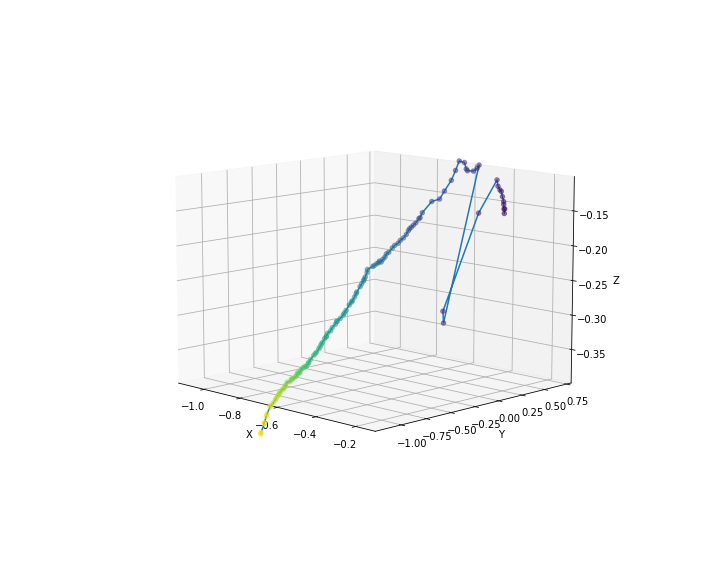

In [111]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.scatter(euler_gt_plt[:, 0], euler_gt_plt[:, 1], euler_gt_plt[:, 2], c=np.arange(len(euler_gt_plt)), alpha=0.1)
sc = ax.plot(euler_plt[:,0], euler_plt[:,1], euler_plt[:,2])
sc = ax.scatter(euler_plt[:,0], euler_plt[:,1], euler_plt[:,2], c=np.arange(len(euler_plt)), alpha=0.5)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim([-1.5, 0.25])
ax.set_ylim([-1.95, 1.5])
ax.set_zlim([-0.5, 0.0])

# plt.colorbar(sc)
plt.show()